<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA-анализ" data-toc-modified-id="EDA-анализ-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA анализ</a></span></li><li><span><a href="#Анализ-Retention-rate" data-toc-modified-id="Анализ-Retention-rate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ Retention rate</a></span></li><li><span><a href="#Анализ-LTV" data-toc-modified-id="Анализ-LTV-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ LTV</a></span><ul class="toc-item"><li><span><a href="#Создание-когорты-доходы-пользователей-по-месяцам" data-toc-modified-id="Создание-когорты-доходы-пользователей-по-месяцам-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание когорты доходы пользователей по месяцам</a></span></li><li><span><a href="#Расчет-LTV" data-toc-modified-id="Расчет-LTV-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Расчет LTV</a></span></li></ul></li><li><span><a href="#RFM-анализ" data-toc-modified-id="RFM-анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RFM анализ</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Проанализируем-данные-на-выбросы" data-toc-modified-id="Проанализируем-данные-на-выбросы-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проанализируем данные на выбросы</a></span></li><li><span><a href="#Подсчет-RFM-score" data-toc-modified-id="Подсчет-RFM-score-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Подсчет RFM score</a></span></li><li><span><a href="#Проверка-нашей-модели-RFM" data-toc-modified-id="Проверка-нашей-модели-RFM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Проверка нашей модели RFM</a></span><ul class="toc-item"><li><span><a href="#Heatmap-от-score-RFM" data-toc-modified-id="Heatmap-от-score-RFM-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Heatmap от score RFM</a></span></li><li><span><a href="#Проверка-метрик-uplift,-gini-за-ноябрь-(2016-11-01)" data-toc-modified-id="Проверка-метрик-uplift,-gini-за-ноябрь-(2016-11-01)-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Проверка метрик uplift, gini за ноябрь (<em>2016-11-01</em>)</a></span></li></ul></li></ul></li><li><span><a href="#Создание-модели-предсказания-LTV" data-toc-modified-id="Создание-модели-предсказания-LTV-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Создание модели предсказания LTV</a></span></li></ul></div>

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go

from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scikitplot.helpers import cumulative_gain_curve
from sklearn import metrics

from tqdm import tqdm
import itertools

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

Данные были взяты из соревнования kaggle:  
https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions

# EDA анализ

In [259]:
df = pd.read_csv("scanner_data.csv", sep=",", encoding='Latin-1')

In [260]:
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [261]:
df.shape

(131706, 8)

8 столбцов,131706 строк

Пропущенных значений - нет

In [262]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

In [263]:
df['Date'].min()

Timestamp('2016-01-02 00:00:00')

In [264]:
df['Date'].max()

Timestamp('2016-12-31 00:00:00')

In [265]:
len(df['Customer_ID'].unique())

22625

22625 уникальных пользователей

In [266]:
df = df.drop(columns = ['Unnamed: 0'])

In [267]:
df.isna().mean()

Date              0.0
Customer_ID       0.0
Transaction_ID    0.0
SKU_Category      0.0
SKU               0.0
Quantity          0.0
Sales_Amount      0.0
dtype: float64

In [268]:
df.dtypes

Date              datetime64[ns]
Customer_ID                int64
Transaction_ID             int64
SKU_Category              object
SKU                       object
Quantity                 float64
Sales_Amount             float64
dtype: object

Все данные в нужном нам виде

# Анализ Retention rate

In [269]:
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88


In [270]:
df['first_date'] = df.groupby('Customer_ID')['Date'].transform('min')
#используем transform тк выводит минимальную дату для каждого пользователя *индексно*

In [271]:
df['last_date'] = df.groupby('Customer_ID')['Date'].transform('max')

In [272]:
df['invoice_month'] = df['Date'].apply(lambda x: dt.datetime(x.year, x.month, 1)) #первый день месяца нашей даты

In [273]:
df['first_month'] = df.groupby('Customer_ID')['Date'].transform('min').apply(lambda x: dt.datetime(x.year, x.month, 1)) 
#выводим первый день месяца для минимальной даты для каждого ID 

In [274]:
df['duration_month'] = df['Date'].dt.month - df['first_date'].dt.month + 1

In [275]:
group_cohort = df.groupby(['first_month','duration_month'])

In [276]:
cohort_data = df.groupby(['first_month','duration_month'])['Customer_ID'].nunique().reset_index()
#подсчет уникальных значений

In [277]:
cohort_counts = cohort_data.pivot(index='first_month', columns='duration_month', values='Customer_ID')
#строим пивот в одном представлении (в ячейках будут ID клиентов)

In [278]:
cohort_sizes = cohort_counts.iloc[:,0] 

In [279]:
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(4)*100

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,
2016-01-01,100.0,38.46,30.18,17.58,7.83,5.80,4.48,4.03,2.65,1.65,1.21,1.18
2016-02-01,100.0,21.52,13.10,6.62,4.28,3.06,3.06,2.57,0.99,0.81,0.63,NaN
2016-03-01,100.0,28.24,24.64,22.71,20.06,19.72,20.06,19.38,19.42,20.14,NaN,NaN
2016-04-01,100.0,28.81,25.05,21.88,22.40,23.55,22.40,22.44,22.99,NaN,NaN,NaN
2016-05-01,100.0,23.84,21.29,19.23,21.55,20.98,19.84,19.92,NaN,NaN,NaN,NaN
2016-06-01,100.0,17.72,17.46,17.85,17.72,17.65,19.12,NaN,NaN,NaN,NaN,NaN
2016-07-01,100.0,14.18,15.09,15.58,15.00,16.57,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,100.0,15.38,13.02,13.49,11.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,100.0,19.02,16.18,18.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


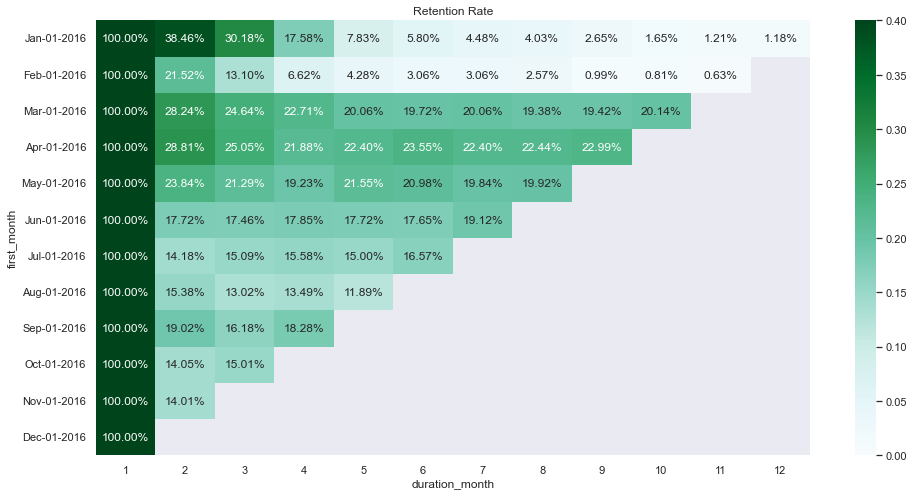

In [280]:
pd.to_datetime(retention.index)
plt.subplots(figsize=(16, 8))
sns.set()
ax = sns.heatmap(data=retention, annot=True, fmt='.2%', vmin=0.0, vmax=0.4, cmap='BuGn')
ax.set_yticklabels(retention.iloc[:].index.strftime('%b-%d-%Y'))
plt.yticks()
plt.title('Retention Rate')
plt.show()

Мы построили когортный анализ ретеншена. Теперь построим когортный анализ значения продаж за каждый месяц

Посмотрим на распределения продаж за каждый месяц

In [281]:
date_unique =  pd.unique(df['invoice_month'].dt.strftime('%Y-%m-%d'))

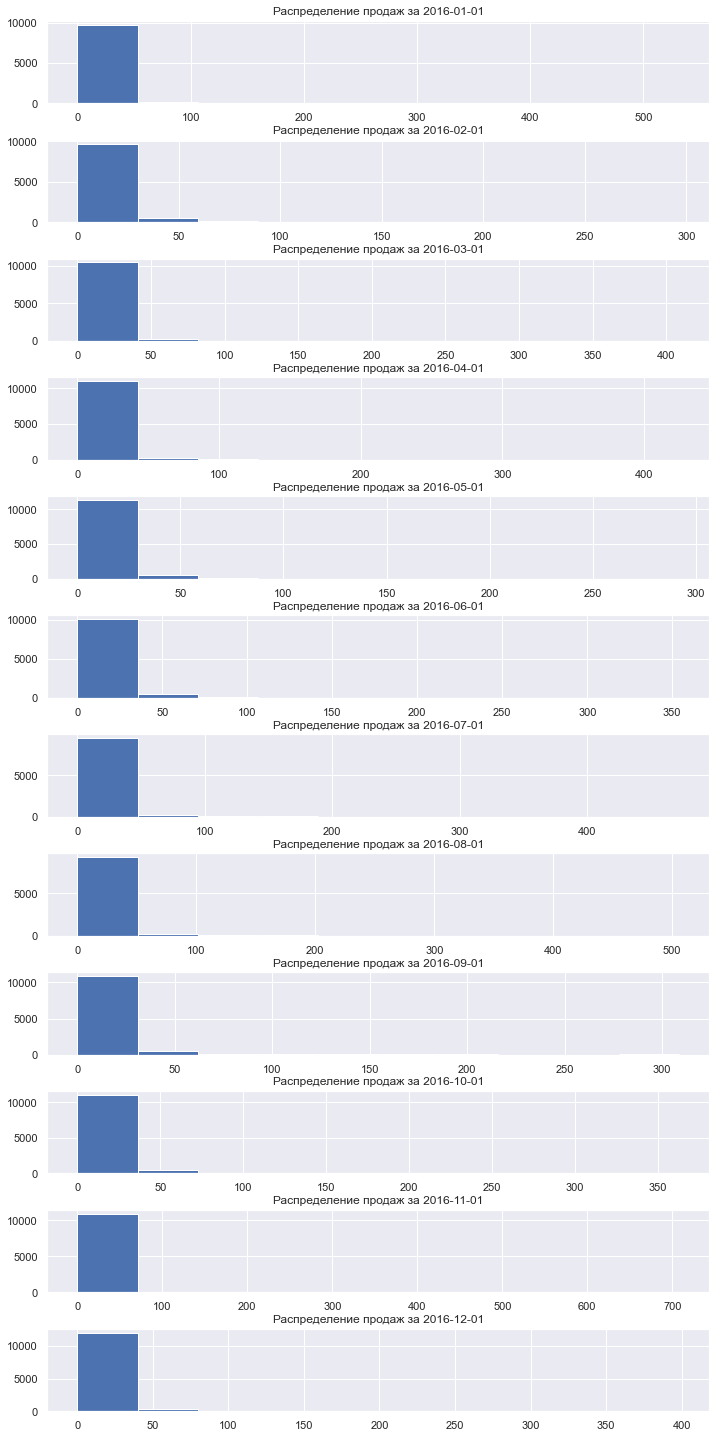

In [282]:
fig, axs = plt.subplots(nrows= len(date_unique) , ncols= 1, figsize=(10,20) )
fig.tight_layout()
for i in range(len(date_unique)):
    axs[i].set_title(f'Распределение продаж за {date_unique[i]}',fontsize = 12)
    axs[i].hist(df[df['invoice_month'] == date_unique[i]]['Sales_Amount'])

На графиках видно, что в каждом распределении за каждый месяц присутствуют выбросы. Убедимся в этом с помощью Boxplot

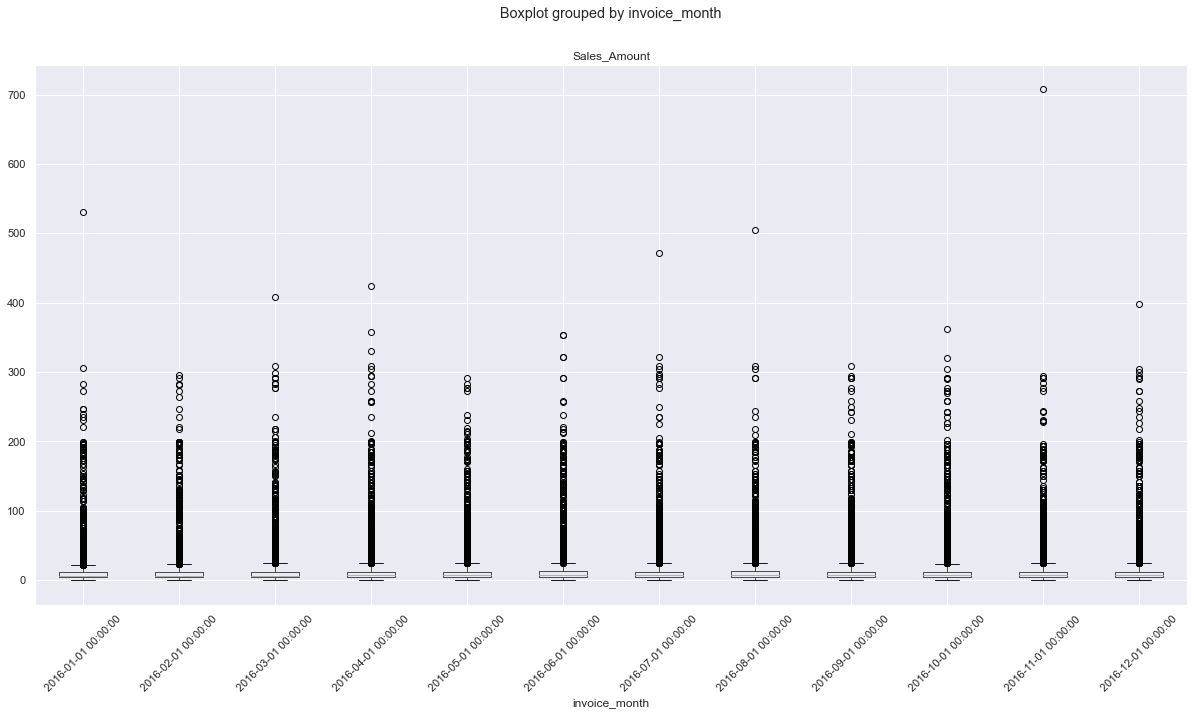

In [283]:
ax = df.boxplot('Sales_Amount', by='invoice_month',figsize=(20,10))
ax.tick_params(axis='x', labelrotation=45)

Как мы видим на графиках присутствует большое кол-во выбросов, поэтому для более корректной оценки продаж воспользуемся медианным значением

In [284]:
cohort_sales = df.groupby(['first_month','duration_month'])['Sales_Amount'].median().reset_index()

In [285]:
average_sales = cohort_sales.pivot(index='first_month', columns='duration_month', values='Sales_Amount')
average_sales.round(2)

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,
2016-01-01,6.69,6.75,7.02,6.75,6.58,6.75,6.18,5.77,6.22,5.15,5.42,6.1
2016-02-01,6.75,6.75,7.24,7.10,7.23,6.81,7.08,7.19,7.23,6.70,7.96,NaN
2016-03-01,6.75,7.23,7.35,7.25,7.43,7.29,7.27,7.56,7.37,7.37,NaN,NaN
2016-04-01,6.81,7.23,7.38,7.44,7.23,7.17,6.92,7.24,7.23,NaN,NaN,NaN
2016-05-01,6.87,7.17,7.12,7.15,6.75,6.81,7.00,6.90,NaN,NaN,NaN,NaN
2016-06-01,7.02,6.92,7.16,6.68,6.35,6.82,6.82,NaN,NaN,NaN,NaN,NaN
2016-07-01,6.75,6.61,6.75,6.75,7.06,6.75,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,6.83,7.00,7.25,7.29,7.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,6.75,6.35,6.75,6.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


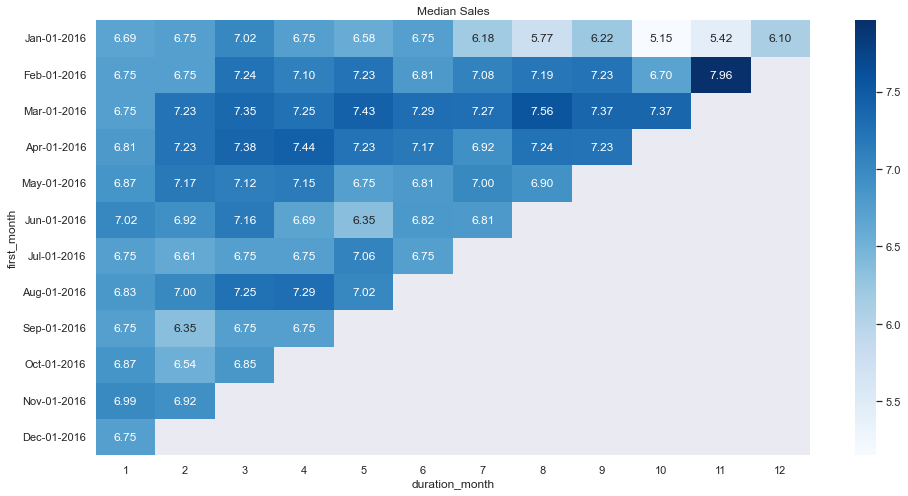

In [286]:
pd.to_datetime(average_sales.index)
plt.subplots(figsize=(16, 8))
sns.set()
ax = sns.heatmap(data=average_sales, annot=True, fmt='.2f',cmap='Blues')
ax.set_yticklabels(average_sales.iloc[:].index.strftime('%b-%d-%Y'))
plt.yticks()
plt.title('Median Sales')
plt.show()

Также для сравнения построим продажи со средним значением по месяцам

In [287]:
cohort_sales = df.groupby(['first_month','duration_month'])['Sales_Amount'].mean().reset_index()

In [288]:
average_sales = cohort_sales.pivot(index='first_month', columns='duration_month', values='Sales_Amount')

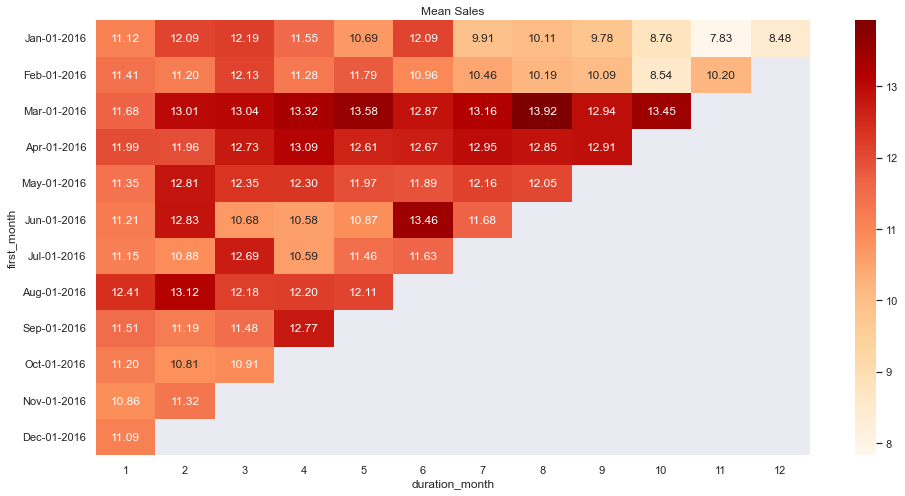

In [289]:
pd.to_datetime(average_sales.index)
plt.subplots(figsize=(16, 8))
sns.set()
ax = sns.heatmap(data=average_sales, annot=True, fmt='.2f',cmap='OrRd')
ax.set_yticklabels(average_sales.iloc[:].index.strftime('%b-%d-%Y'))
plt.yticks()
plt.title('Mean Sales')
plt.show()

# Анализ LTV

LTV (Lifetime Value) — это валовая прибыль, которую средний пользователь принесет за все время использования продукта.  
В данном случае LTV будем расчитывать на основе дохода (Revenue) т.к. нам не известна себестоимость продукции
> В классическом варианте подсчета LTV используют валовую прибыль (Gross Profit)  

LTV будем расчитывать исходя из следующих пунктов:
1. Берем когорту пользователей и для каждого пользователя считаем доход в динамике по месяцам с момента первой покупки.
2. Считаем суммарный доход от всей когорты пользователей в динамике по месяцам с момента первой покупки.
3. На основе прошлого пункта считаем кумулятивный доход когорты пользователей в динамике по месяцам. Прибыль дня N будет равна прибыли за дни с 0 по N.
4. Делим кумулятивный доход на количество пользователей в когорте и получаем динамику LTV когорты пользователей по месяцам.

Источник: https://gopractice.ru/product/how-to-calculate-ltv/

## Создание когорты доходы пользователей по месяцам

In [290]:
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,first_date,last_date,invoice_month,first_month,duration_month
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2016-01-02,2016-04-16,2016-01-01,2016-01-01,1
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2016-01-02,2016-02-03,2016-01-01,2016-01-01,1
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2016-01-02,2016-03-08,2016-01-01,2016-01-01,1
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2016-01-02,2016-03-05,2016-01-01,2016-01-01,1
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2016-01-02,2016-04-09,2016-01-01,2016-01-01,1


In [291]:
cohort_user_ltv = df.pivot_table(index=['Customer_ID'],columns=['duration_month'],values='Sales_Amount',aggfunc='sum',fill_value=0)
cohort_user_ltv

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
Customer_ID,,,,,,,,,,,,
1,16.29,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,7.77,0.00,0.0,15.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,10.92,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,6.69,0.00,0.0,0.00,26.6,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,40.26,17.17,0.0,14.33,0.0,7.06,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
22621,9.69,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
22622,6.07,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
22623,128.01,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
def highlight_cells(val, color_if_true, color_if_false):
    color = color_if_true if val != 0 else color_if_false
    return 'background-color: {}'.format(color)

cohort_user_ltv[:10].style.applymap(highlight_cells, color_if_true='#AFDCAB', color_if_false='#E0D5CA')

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
Customer_ID,,,,,,,,,,,,
1,16.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,7.770000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,10.920000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,6.690000,0.000000,0.000000,0.000000,26.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,40.260000,17.170000,0.000000,14.330000,0.000000,7.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,25.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,17.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,9.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,15.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


В датафрейме cohort_user_ltv получили доход каждого пользователей в динамике с первого месяца 

## Расчет LTV

Прибыль от когорты пользователей в динамике по месяцам с момента первой покупки

In [293]:
revenue_month = df.groupby('duration_month')['Sales_Amount'].sum().reset_index()
revenue_month

,duration_month,Sales_Amount
0,1,613323.38
1,2,198473.51
2,3,162588.43
3,4,126032.92
4,5,104718.15
5,6,100328.98
6,7,95986.57
7,8,80831.61
8,9,58277.75
9,10,34213.10


Кумулятивная прибыль от когорты пользователей в динамике по месяцам с момента первой покупки

In [294]:
cum_revenue_month = revenue_month
cum_revenue_month['Sales_Amount'] = cum_revenue_month['Sales_Amount'].cumsum()
cum_revenue_month

,duration_month,Sales_Amount
0,1,613323.38
1,2,811796.89
2,3,974385.32
3,4,1100418.24
4,5,1205136.39
5,6,1305465.37
6,7,1401451.94
7,8,1482283.55
8,9,1540561.30
9,10,1574774.40


LTV когорты пользователей в динамике по месяцам с момента первой покупки

In [295]:
cum_revenue_month['LTV'] = cum_revenue_month['Sales_Amount'] / len(df['Customer_ID'].unique())
cum_revenue_month

,duration_month,Sales_Amount,LTV
0,1,613323.38,27.108216
1,2,811796.89,35.880526
2,3,974385.32,43.066754
3,4,1100418.24,48.637270
4,5,1205136.39,53.265697
5,6,1305465.37,57.700127
6,7,1401451.94,61.942627
7,8,1482283.55,65.515295
8,9,1540561.30,68.091107
9,10,1574774.40,69.603288


# RFM анализ

## Подготовка данных

Для RFM анализа мы возьмем последние 6 месяцев.  
Найдем значения данных столбцов и оценим их от 1 до 4:  

recency (как давно что-то покупал? Чем более недавно, тем лучше) 1-4  
frequency (как часто покупал ранее? Чем чаще, тем лучше) 1-4  
monetary (как много денег потратил на нас? Чем больше, тем лучше) 1-4  

In [296]:
rfm_df = df[df['Date'] >= '2016-06-01']

In [297]:
rfm_df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,first_date,last_date,invoice_month,first_month,duration_month
54719,2016-06-01,3771,27197,LPF,EFRI7,1.0,23.59,2016-02-08,2016-06-01,2016-06-01,2016-02-01,5
54720,2016-06-01,3771,27197,IEV,MAG1S,2.0,5.50,2016-02-08,2016-06-01,2016-06-01,2016-02-01,5
54721,2016-06-01,3771,27197,OXH,DCQM1,1.0,20.82,2016-02-08,2016-06-01,2016-06-01,2016-02-01,5
54722,2016-06-01,3771,27197,EKM,Q9G2U,1.0,3.13,2016-02-08,2016-06-01,2016-06-01,2016-02-01,5
54723,2016-06-01,3771,27197,6BZ,7404D,1.0,16.80,2016-02-08,2016-06-01,2016-06-01,2016-02-01,5


Методом группировки подсчитаем для каждого клиента:  
1. Кол-во заработанных денег  
2. Дату последней покупки
3. Сколько раз клиент покупал товар  
4. Найдем кол-во дней с последней покупки (за конец даты возьмем последний день периода *2016-12-31* 

In [298]:
rfm = rfm_df.groupby('Customer_ID')['Sales_Amount'].sum().reset_index()

In [299]:
rfm = rfm.merge(rfm_df.groupby('Customer_ID')['Date'].max().reset_index())

In [300]:
rfm = rfm.merge(rfm_df.groupby('Customer_ID')['Quantity'].sum().reset_index())

In [301]:
rfm = rfm.rename(columns = {'Date':'Last_date_purches', 'Sales_Amount':'monetary','Quantity':'frequency'})

In [302]:
rfm['Date_max'] = pd.Timestamp('2016-12-31')

In [303]:
rfm['recency'] = (rfm['Date_max']-rfm['Last_date_purches']).astype('timedelta64[D]')

In [304]:
rfm.shape

(13745, 6)

In [305]:
rfm.head()

,Customer_ID,monetary,Last_date_purches,frequency,Date_max,recency
0,2,15.00,2016-06-19,1.0,2016-12-31,195.0
1,4,33.29,2016-11-09,5.0,2016-12-31,52.0
2,5,7.06,2016-07-05,1.0,2016-12-31,179.0
3,7,17.84,2016-10-05,1.0,2016-12-31,87.0
4,8,9.78,2016-06-21,2.0,2016-12-31,193.0


## Проанализируем данные на выбросы

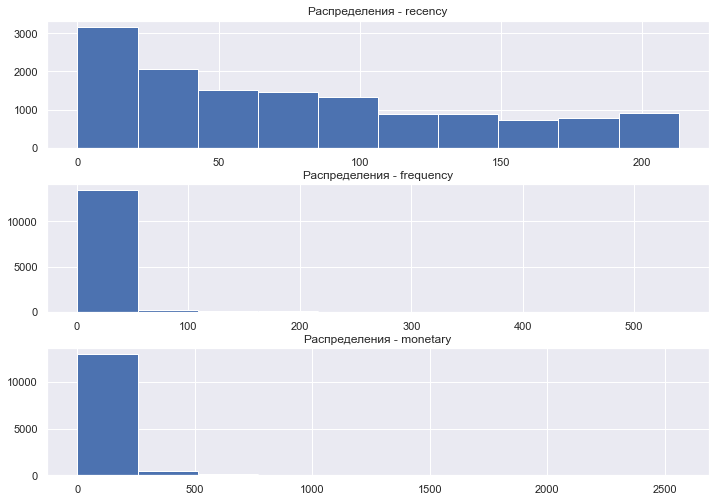

In [306]:
name_col = ['recency','frequency','monetary']
fig, axs = plt.subplots(nrows= len(name_col) , ncols= 1, figsize=(10,7) )
fig.tight_layout()
for i in range(len(name_col)):
    axs[i].set_title(f'Распределения - {name_col[i]}',fontsize = 12)
    axs[i].hist(rfm[name_col[i]])

Из графиков распределения видно, что показатели frequency и monetary имееют большое кол-во выбросов.
Уберем выбросы с показателя monetary

<AxesSubplot:>

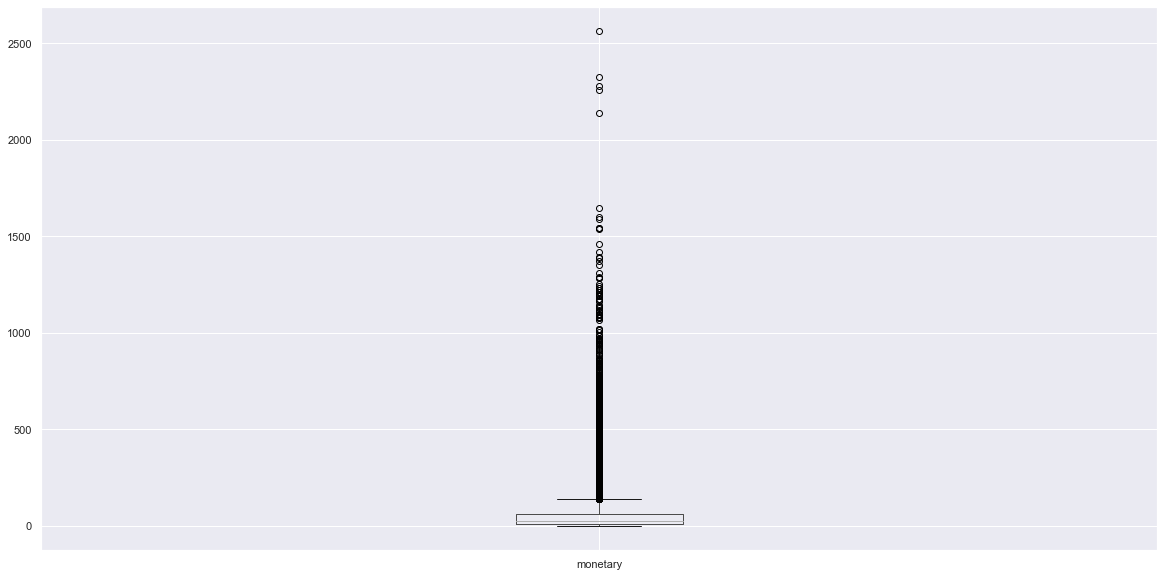

In [307]:
rfm.boxplot('monetary',figsize=(20,10))

На графике boxplot, также отчетливо видны выбросы

Выбросы будем считать по формуле:  
$ lower = 25percentile - (1.5 * IQR) $  
$ upper = 75percentile + (1.5 * IQR) $  

,где IQR - межквантильное расстояние между первым и третьем квантилем

In [308]:
Q1 = rfm['monetary'].quantile(0.25)
Q3 = rfm['monetary'].quantile(0.75)
IQR = Q3 - Q1

In [309]:
lower = rfm['monetary'].quantile(0.25) - (1.5 * IQR)
upper = rfm['monetary'].quantile(0.75) + (1.5 * IQR)
print("Нижняя граница: ", lower)
print("Верхняя граница: ", upper)

Нижняя граница:  -66.94
Верхняя граница:  138.9


Отсечем выбросы:

<AxesSubplot:>

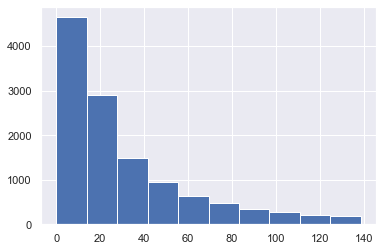

In [310]:
rfm[(rfm["monetary"] >= lower) & (rfm['monetary'] <= upper)]['monetary'].hist()

<AxesSubplot:>

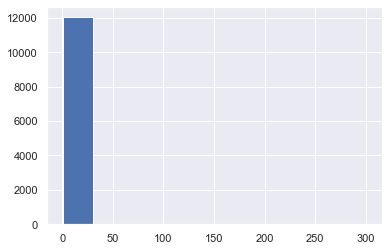

In [311]:
rfm[(rfm["monetary"] >= lower) & (rfm['monetary'] <= upper)]['frequency'].hist()

Мы убрали выбросы в monetary и сократили их кол-во в frequency, однако нам надо польностью от их избавится для frequency

In [312]:
rfm = rfm[(rfm["monetary"] >= lower) & (rfm['monetary'] <= upper)]

In [313]:
rfm.head()

,Customer_ID,monetary,Last_date_purches,frequency,Date_max,recency
0,2,15.00,2016-06-19,1.0,2016-12-31,195.0
1,4,33.29,2016-11-09,5.0,2016-12-31,52.0
2,5,7.06,2016-07-05,1.0,2016-12-31,179.0
3,7,17.84,2016-10-05,1.0,2016-12-31,87.0
4,8,9.78,2016-06-21,2.0,2016-12-31,193.0


In [314]:
rfm.shape

(12114, 6)

**Избавимся от выбросов для frequency**

<AxesSubplot:>

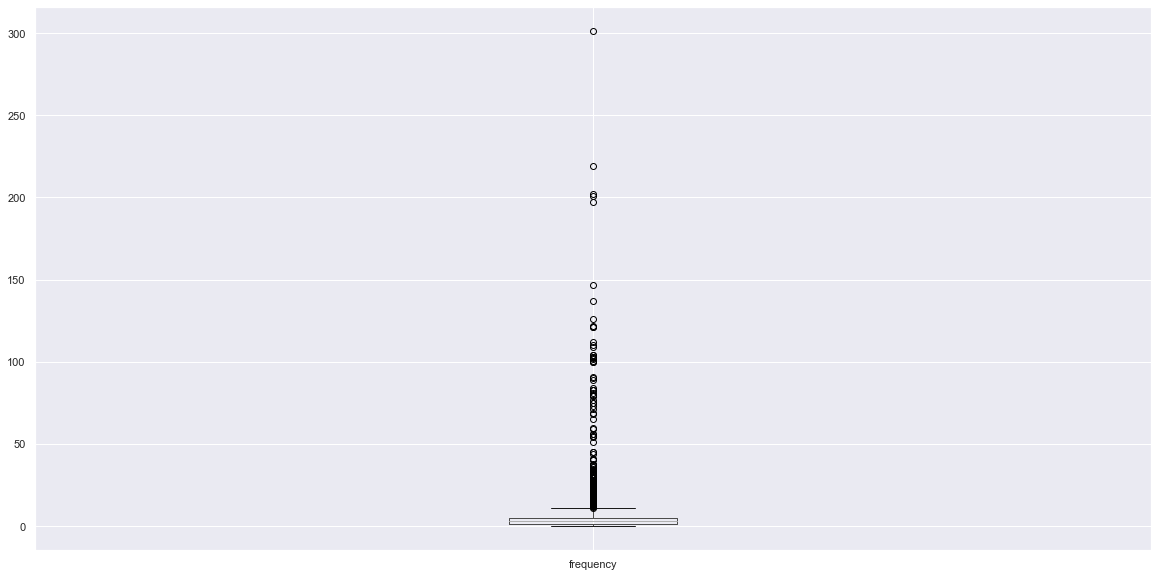

In [315]:
rfm.boxplot('frequency',figsize=(20,10))

In [316]:
Q1 = rfm['frequency'].quantile(0.25)
Q3 = rfm['frequency'].quantile(0.75)
IQR = Q3 - Q1

In [317]:
lower = rfm['frequency'].quantile(0.25) - (1.5 * IQR)
upper = rfm['frequency'].quantile(0.75) + (1.5 * IQR)
print("Нижняя граница: ", lower)
print("Верхняя граница: ", upper)

Нижняя граница:  -5.0
Верхняя граница:  11.0


<AxesSubplot:>

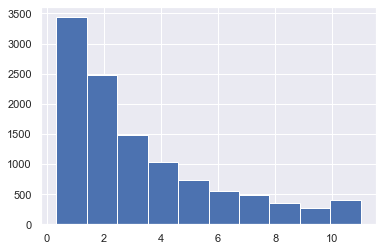

In [318]:
rfm[(rfm["frequency"] >= lower) & (rfm['frequency'] <= upper)]['frequency'].hist()

Убрали выбросы в frequency, теперь сохраним данные

In [319]:
rfm = rfm[(rfm["frequency"] >= lower) & (rfm['frequency'] <= upper)]

In [320]:
rfm.head()

,Customer_ID,monetary,Last_date_purches,frequency,Date_max,recency
0,2,15.00,2016-06-19,1.0,2016-12-31,195.0
1,4,33.29,2016-11-09,5.0,2016-12-31,52.0
2,5,7.06,2016-07-05,1.0,2016-12-31,179.0
3,7,17.84,2016-10-05,1.0,2016-12-31,87.0
4,8,9.78,2016-06-21,2.0,2016-12-31,193.0


In [321]:
rfm.shape

(11220, 6)

## Подсчет RFM score

Каждую метрику из RFM будем разделять на 4 относительно равных отрезка

In [322]:
rfm['recency_score'] = 5 - (pd.qcut(rfm['recency'], 4, labels= False) +1)

In [323]:
rfm['recency_score'].value_counts()

4    2821
3    2815
2    2793
1    2791
Name: recency_score, dtype: int64

In [324]:
rfm['frequency_score'] = (pd.qcut(rfm['frequency'], 4, labels= False) +1)

Видим, что в поле frequency имеются десятичные числа покупок (видимо покупали что-то весовое: фрукты, овощи и т.д.)

In [325]:
rfm.groupby("frequency_score")['frequency'].agg(set)

frequency_score
1        {0.33, 1.0, 0.34, 0.5, 0.99, 0.66, 0.67, 0.7}
2           {1.33, 2.0, 1.6600000000000001, 1.5, 1.34}
3    {2.34, 3.5, 3.0, 4.0, 4.5, 2.2, 2.66, 2.33, 3....
4    {4.75, 5.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11....
Name: frequency, dtype: object

In [326]:
rfm['frequency_score'].value_counts()

1    3430
4    2805
3    2515
2    2470
Name: frequency_score, dtype: int64

In [327]:
rfm['monetary_score'] =  (pd.qcut(rfm['monetary'], 4, labels= False) +1)

In [328]:
rfm['monetary_score'].value_counts()

1    2817
3    2805
4    2805
2    2793
Name: monetary_score, dtype: int64

Найдем средний RFM score

In [329]:
rfm['rfm_score'] = (rfm['monetary_score']  + rfm['frequency_score'] + rfm['recency_score']) / 3

In [330]:
rfm['rfm_categories'] = rfm['recency_score'].astype(str) + '' + rfm['frequency_score'].astype(str) +''+ rfm['monetary_score'].astype(str)

In [331]:
rfm['sum_rfm'] = rfm['recency_score'] + rfm['frequency_score'] + rfm['monetary_score']

In [332]:
rfm.head()

,Customer_ID,monetary,Last_date_purches,frequency,Date_max,recency,recency_score,frequency_score,monetary_score,rfm_score,rfm_categories,sum_rfm
0,2,15.00,2016-06-19,1.0,2016-12-31,195.0,1,1,2,1.333333,112,4
1,4,33.29,2016-11-09,5.0,2016-12-31,52.0,3,4,3,3.333333,343,10
2,5,7.06,2016-07-05,1.0,2016-12-31,179.0,1,1,1,1.000000,111,3
3,7,17.84,2016-10-05,1.0,2016-12-31,87.0,2,1,3,2.000000,213,6
4,8,9.78,2016-06-21,2.0,2016-12-31,193.0,1,2,2,1.666667,122,5


## Проверка нашей модели RFM

### Heatmap от score RFM

In [333]:
rfm.pivot_table(index='frequency_score',columns='recency_score',values='monetary',aggfunc='sum')

recency_score,1,2,3,4
frequency_score,,,,
1,11145.78,8641.31,7774.91,6902.83
2,12088.25,11130.88,10563.63,9233.99
3,14735.21,17783.71,19063.28,19488.02
4,19229.69,28007.05,41122.26,59697.34


<AxesSubplot:xlabel='recency_score', ylabel='frequency_score'>

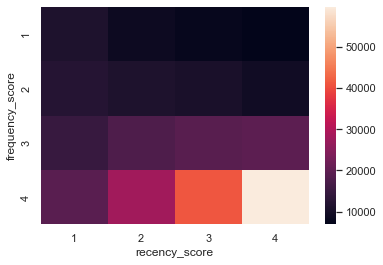

In [334]:
sns.heatmap(rfm.pivot_table(index='frequency_score',columns='recency_score',values='monetary',aggfunc='sum'))

Построим 3D визуализацию heatmap

In [335]:
matrix = (rfm[rfm['monetary']>0].groupby(['recency_score', 'frequency_score', 'monetary_score'])[['monetary']].sum()
            .reset_index())

fig = px.scatter_3d(matrix, x='recency_score', y='frequency_score', z='monetary_score',
              color='monetary')
fig.show()

Из данных таблицы и heatmap видна зависимость monetary от расчитанных показателей frequency_score и recency_score, чем больше этих два показателя, тем больше monetary

### Проверка метрик uplift, gini за ноябрь (*2016-11-01*)

In [336]:
rfm_november = rfm_df[rfm_df['invoice_month'] == '2016-11-01'].groupby('Customer_ID')['Sales_Amount'].sum().reset_index()

In [337]:
rfm_november = rfm_november.rename(columns = {'Sales_Amount':'Sales_november'})

In [338]:
rfm_november.head()

,Customer_ID,Sales_november
0,4,26.60
1,150,3.88
2,209,13.00
3,265,7.77
4,442,11.75


In [339]:
rfm = rfm.merge(rfm_november, how='left',left_on='Customer_ID',right_on='Customer_ID')

In [340]:
rfm['has_purchase'] = (rfm['Sales_november'] > 0 ) * 1

In [341]:
rfm['has_purchase'].mean()

0.22032085561497325

Из всех клиентов в базе за анализируемый период по октябрь (до ноября), клиентов который совершали покупки в ноябре - 22%

In [342]:
rfm.sample(frac=0.2)['has_purchase'].sum()/rfm['has_purchase'].sum() #достигаем рандомно

0.20631067961165048

Показывает, сколько % покупателей совершали покупок в ноябре из 20% **рандомных** покупателей из RFM 

In [343]:
rfm.sort_values('rfm_score', ascending = False, inplace=True)

In [344]:
rfm.head(int(len(rfm) * 0.2))['has_purchase'].sum()/rfm['has_purchase'].sum() 
#в два раза лучшем находим, чем рандом, тех кто что либо купит в след. месяце 

0.4008899676375405

In [345]:
print("Число покупателей в ноябре из 20% лучших покупателей по RFM: ",rfm.head(int(len(rfm) * 0.2))['has_purchase'].sum())

Число покупателей в ноябре из 20% лучших покупателей по RFM:  991


In [346]:
print("Число всех покупателей в ноябре: ",rfm['has_purchase'].sum())

Число всех покупателей в ноябре:  2472


Данное число (0.4) показывает, что из 20% лучших покупателей по RFM score в ноябре кол-во покупателей было 991 из всех 2472 покупателей, то есть 40% 

Посчитаем метрику uplift, которая показывает насколько наша модель отличается от рандома для лучших 20% покупателей RFM

In [347]:
rfm.head(int(len(rfm) * 0.2))['has_purchase'].sum()/rfm['has_purchase'].sum() / 0.2

2.004449838187702

Для того, чтобы посчитать каждый процент покупателей RFM (от 1% - 100%) построим график cumulative_gain_curve

Найдем показатель uplift для каждого процента покупателей RFM

In [348]:
per, gain = cumulative_gain_curve(rfm['has_purchase'], rfm['rfm_score'])

Найдем идеальные показатели uplift (для нашей модели)

In [349]:
_, ideal = cumulative_gain_curve(rfm['has_purchase'], rfm['has_purchase'])

In [350]:
lc = pd.DataFrame({'per':per,'gain':gain})

In [351]:
lc['random'] = lc['per']

In [352]:
lc['ideal'] = ideal

<AxesSubplot:xlabel='per'>

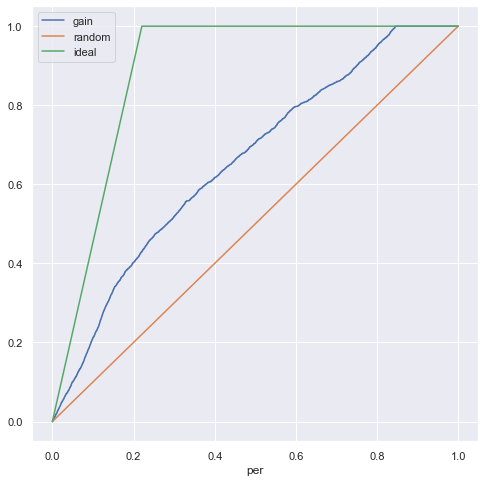

In [353]:
lc.plot(x='per',y=['gain','random','ideal'], figsize=(8,8),grid=True)

На графике отложены три линии:  
1. Синия линия показывает (gain) нашу модель RFM score
2. Оранжевая линия (random) показывает рандомное предсказание
3. Зеленая линия (ideal) показывает лучшую модель

Найдем метрику gini. Данная метрика является отношением площадей под графиком нашей модели к наилучшей

In [354]:
model_auc = auc(lc['per'],lc['gain']) - 0.5

In [355]:
ideal_auc = auc(lc['per'],lc['ideal']) - 0.5

In [356]:
gini = model_auc / ideal_auc #gini

In [357]:
gini

0.4066980450825192

Показатель gini = 0.4

# Создание модели предсказания LTV

In [358]:
df["invoice_month_sh"] = pd.to_datetime(df["invoice_month"]).dt.strftime('%Y-%m')

In [359]:
sales = df.pivot_table(index=['Customer_ID'],columns=['invoice_month_sh'],values='Sales_Amount',aggfunc='sum',fill_value=0)

Возьмем данные для прогнозирования LTV:
1. Без выбросов (во время RFM анализа мы избавились от выбросов)
2. Последние 6 месяцев (т.к. RFM анализ был сделан за последние 6 месяцев)

In [360]:
sales_6mt = sales.iloc[:,5:]

In [361]:
sales_6mt['LTV'] = sales_6mt.iloc[:].sum(axis=1)
sales_6mt.head()

invoice_month_sh,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,LTV
Customer_ID,,,,,,,,
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00
2,15.0,0.00,0.0,0.0,0.0,0.0,0.0,15.00
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,6.69,0.0,0.0,0.0,26.6,0.0,33.29
5,0.0,7.06,0.0,0.0,0.0,0.0,0.0,7.06


In [362]:
rfm_2col = rfm[['Customer_ID','sum_rfm']]

In [363]:
ltv_rfm = pd.merge(sales_6mt, rfm_2col, on='Customer_ID', how='left')

In [364]:
ltv_rfm = ltv_rfm[ltv_rfm['sum_rfm'].notna()]

In [365]:
ltv_rfm['Segment'] = 'Low-Value'
ltv_rfm.loc[ltv_rfm['sum_rfm']>5,'Segment'] = 'Mid-Value' 
ltv_rfm.loc[ltv_rfm['sum_rfm']>8,'Segment'] = 'High-Value' 

In [366]:
ltv_rfm.head()

,Customer_ID,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,LTV,sum_rfm,Segment
1,2,15.00,0.00,0.0,0.0,0.00,0.0,0.0,15.00,4.0,Low-Value
3,4,0.00,6.69,0.0,0.0,0.00,26.6,0.0,33.29,10.0,High-Value
4,5,0.00,7.06,0.0,0.0,0.00,0.0,0.0,7.06,3.0,Low-Value
6,7,0.00,0.00,0.0,0.0,17.84,0.0,0.0,17.84,6.0,Mid-Value
7,8,9.78,0.00,0.0,0.0,0.00,0.0,0.0,9.78,5.0,Low-Value


In [367]:
ltv_rfm_graph = ltv_rfm

plot_data = [
    go.Scatter(
        x=ltv_rfm_graph.query("Segment == 'Low-Value'")['sum_rfm'],
        y=ltv_rfm_graph.query("Segment == 'Low-Value'")['LTV'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=ltv_rfm_graph.query("Segment == 'Mid-Value'")['sum_rfm'],
        y=ltv_rfm_graph.query("Segment == 'Mid-Value'")['LTV'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=ltv_rfm_graph.query("Segment == 'High-Value'")['sum_rfm'],
        y=ltv_rfm_graph.query("Segment == 'High-Value'")['LTV'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

На данном рисунке отчетливо видна корреляция. Высокий показатель RFM означает высокий LTV покупателя

Для того чтобы предсказать LTV воспользуемся классификацией на основе RFM анализа. Для этого мы разбили выборку на 3 категории по сумме баллов RFM:  
- Low-Value
- Mid-Value
- High-Value

In [368]:
ltv_rfm_graph['Segment'] = ltv_rfm_graph['Segment'].astype('category')

In [369]:
ltv_rfm_graph['Segment'] = ltv_rfm_graph['Segment'].cat.codes
#закодируем категориальную переменную на (0,1,2)

In [370]:
ltv_rfm_graph.head()

,Customer_ID,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,LTV,sum_rfm,Segment
1,2,15.00,0.00,0.0,0.0,0.00,0.0,0.0,15.00,4.0,1
3,4,0.00,6.69,0.0,0.0,0.00,26.6,0.0,33.29,10.0,0
4,5,0.00,7.06,0.0,0.0,0.00,0.0,0.0,7.06,3.0,1
6,7,0.00,0.00,0.0,0.0,17.84,0.0,0.0,17.84,6.0,2
7,8,9.78,0.00,0.0,0.0,0.00,0.0,0.0,9.78,5.0,1


In [371]:
X = ltv_rfm_graph.drop(['sum_rfm','Segment','LTV'],axis=1)
y = ltv_rfm_graph['Segment']

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
# разбиваем на тестовую и обучающую выборку

In [373]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.86
Accuracy of XGB classifier on test set: 0.82
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       805
           1       0.79      0.88      0.83       636
           2       0.76      0.72      0.74       803

    accuracy                           0.82      2244
   macro avg       0.82      0.82      0.82      2244
weighted avg       0.82      0.82      0.82      2244



Опираться будем на метрику f1-score т.к. эта метрика объединяет в себе precision и recall: 

$$ F_1 = \frac{2*recall*precision}{recall+precision} $$

Из полученных результатов мы видим, что модель:  
- Для 1 класса правильно индетифицирует 88% покупателей
- Для 2 класса правильно индетифицирует 83% покупателей
- Для 3 класса правильно индетифицирует 74% покупателей

In [374]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         grid=False):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.819
Confusion matrix, without normalization


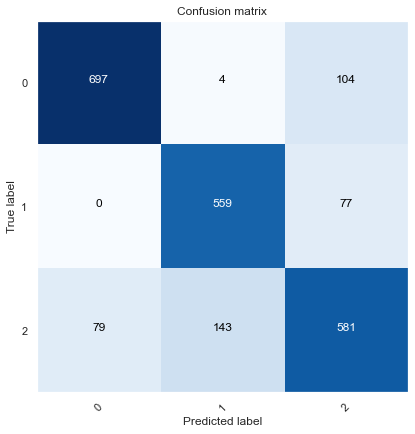

In [375]:
score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, y_pred, labels = list(y_test.unique()))
plot_confusion_matrix(cm, classes= list(y_test.unique()))

Построили матрицу ошибок, на которой можно увидить значения TP, FP, FN, TN для каждого класса Также для каждого класса можно сказать, как предсказала значения классов наша модель